## a) DNN with SGD 

In [1]:
import matplotlib.pyplot as plt, numpy as np, torch, multiprocessing as mp
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import display, clear_output
torch.manual_seed(1)
if torch.cuda.is_available:
    torch.cuda.manual_seed_all(1)
%matplotlib inline

In [2]:
# get dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

# flatten each image to a row [n_data_points X n_pixels]
idat = train_dataset.train_data.view(-1, 28*28).float()

# just a list of numbers
odat = train_dataset.train_labels.view(-1, 1).float()

In [3]:
# make the deep neural network
class DNN(torch.nn.Sequential):
    
    def __init__(self, shape, dropout=False, norm="layer"):
        self.shape = shape
        
        # shape defines hidden architecture, e.g., [n_0, ..., n_j, ..., n_J]
        shape = [28*28] + list(shape) + [1]
        
        # network operations
        ops = []
        
        # create operations
        for i in range(len(shape) - 1):
            
            # layer norm
            if norm == "layer":
                ops.append(torch.nn.LayerNorm(shape[i]))
            elif norm == "batch":
                ops.append(torch.nn.BatchNorm1d(shape[i]))
            
            # linear layer
            ops.append(torch.nn.Linear(shape[i], shape[i + 1]))
            
            # second to last layer
            if i == len(shape) - 2:
                
                # output between 0 and 1
                ops.append(torch.nn.Sigmoid())
                
            # hidden layers
            else:
                
                # dropout
                if dropout:
                    ops.append(torch.nn.Dropout())
                
                # ReLu activation units
                ops.append(torch.nn.ReLU())
                
        # create sequential model with operations
        torch.nn.Sequential.__init__(self, *ops)
        self.float()
        
    def __call__(self, x):
        
        # 0-1 output of network
        y = self.forward(x)
        
        # scale it to 0-9
        return y*9

In [4]:
# define a training function
def train(net, idat, odat, epo=1000, lr=1e-4, gpu=False, ptest=0.1, batches=1):
    
    # if you are smart
    if gpu:
        net.cuda()
        idat = idat.cuda()
        odat = odat.cuda()
        
    # if you are not
    else:
        net.cpu()
        idat = idat.cpu()
        odat = odat.cpu()
        
    # number of testing data points
    n = int(idat.shape[0]*ptest)
    
    # batches of testing data
    itstb = idat[:n, :].chunk(batches)
    otstb = odat[:n, :].chunk(batches)
    
    # batches of training data
    itrnb = idat[n:, :].chunk(batches)
    otrnb = odat[n:, :].chunk(batches)
        
    # optimisation algorithm
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss function
    lf = torch.nn.MSELoss()
    
    # loss records
    training_loss = list()
    testing_loss  = list()
    
    # training iterations
    for e in range(epo):
        
        # losses
        ltrn, ltst = 0, 0
        
        # batch iterations
        for itst, otst, itrn, otrn in zip(itstb, otstb, itrnb, otrnb):
            
            # zero the gradients
            opt.zero_grad()
            
            # compute losses
            loss_train = lf(net(itrn), otrn)
            loss_test  = lf(net(itst), otst)
            
            # records losses
            ltrn += loss_train.item()
            ltst += loss_test.item()
            
            # accumulate gradient
            loss_train.backward()
            
            # take an optimisation step
            opt.step()
        
        # record the average loss across batches
        ltrn /= batches
        ltst /= batches
        training_loss.append(ltrn)
        testing_loss.append(ltst)
        
        # print progress
        clear_output(wait=True)
        print("Episode {}; Training Loss {}; Testing Loss {}".format(e, ltrn, ltst))
        
    return net.cpu(), training_loss, testing_loss

In [5]:
# training parameters
epo, lr, gpu, ptst = 2000, 1e-4, True, 0.1

# number of considered data points
n = 20000

In [6]:
# considered architectures
args = [
    (DNN([50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([50, 50, 50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([100, 100, 100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst, 1)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train, args)

Episode 1999; Training Loss 0.00720403715968132; Testing Loss 0.9866823554039001


In [7]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=r"${}$".format(net.shape))
    ax.plot(losstest, "k--", color=str(c))
    
# plot settings
ax.set_title("Regular SGD")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

In the above plot, the divergence between the training loss (solid lines) and testing loss (dashed lines) indicates the loss of the neural networks' generalisation performance.
We see that with both an increasing number of layers and number of nodes per layer, divergence begins at a lower loss.
The deepest and widest network $[100, 100, 100, 100]$ unsurprisingly has the best generalisation performance.
As expected, we see that the convergence rate decreases as the size of the neural network architecture increases.

# b) DNN with mini batch SGD

In [8]:
# considered architectures
args = [
    (DNN([50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst, 10),
    (DNN([50, 50, 50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst, 10),
    (DNN([100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst, 10),
    (DNN([100, 100, 100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst, 10)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train, args)

Episode 1999; Training Loss 0.0026218133862130344; Testing Loss 0.9032802760601044


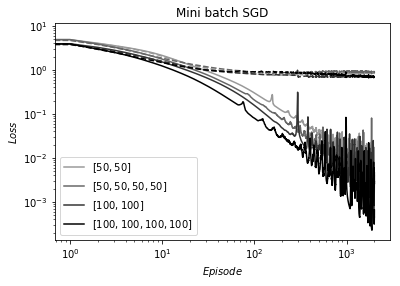

In [9]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=r"${}$".format(net.shape))
    ax.plot(losstest, "k--", color=str(c))
    
# plot settings
ax.set_title("Mini batch SGD")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

We see that, with mini batch gradient descent, the training loss progress becomes more erratic.
However, we also see that the general loss trends remain unchanged.

# c) Different hidden architectures

In [10]:
# considered architectures
args = [
    (DNN([100, 50, 20, 10]), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([10, 20, 50, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst, 1)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train, args)

Episode 1999; Training Loss 0.1734602004289627; Testing Loss 1.2143925428390503


In [11]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=r"${}$".format(net.shape))
    ax.plot(losstest, "k--", color=str(c))
    
# plot settings
ax.set_title("Converging architectures")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

In both parts (a) and (b), we investigated the effect of hidden architecture on performance.
We found that, in general, performance increases as network depth increases.
In the above plot, we can see the difference in performance between a network with decreasing number of nodes per layer and increasing nodes per layer.
We observe that the network with a decreasing number of node per layer achieves better performance.
This is likely because the difference between the dimension of the input and first layer is less, so more information is retained.

# d) Part (a) with 6 workers

In [12]:
def train_six(net, idat, odat, epo=1000, lr=1e-4, gpu=False, ptest=0.1):
    
    # if you are smart
    if gpu:
        net.cuda()
        idat = idat.cuda()
        odat = odat.cuda()
        
    # if you are not
    else:
        net.cpu()
        idat = idat.cpu()
        odat = odat.cpu()
        
    # number of testing data points
    n = int(idat.shape[0]*ptest)
    
    # batches of testing data
    itstb = idat[:n, :].chunk(6)
    otstb = odat[:n, :].chunk(6)
    
    # batches of training data
    itrnb = idat[n:, :].chunk(6)
    otrnb = odat[n:, :].chunk(6)
        
    # optimisation algorithm
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss function
    lf = torch.nn.MSELoss()
    
    # loss records
    training_loss = list()
    testing_loss  = list()
    
    # training iterations
    for e in range(epo):
        
        # losses
        ltrn, ltst = 0, 0
        
        # batch iterations
        for itst, otst, itrn, otrn in zip(itstb, otstb, itrnb, otrnb):
            
            # zero the gradients
            opt.zero_grad()
            
            # compute losses with noise
            loss_train = lf(net(itrn) + np.random.normal(0, 0.1), otrn)
            loss_test  = lf(net(itst) + np.random.normal(0, 0.1), otst)
            
            # records losses
            ltrn += loss_train.item()
            ltst += loss_test.item()
            
            # accumulate gradient
            loss_train.backward()
            
            # take an optimisation step
            opt.step()
        
        # record the average loss across batches
        ltrn /= 6
        ltst /= 6
        training_loss.append(ltrn)
        testing_loss.append(ltst)
        
        # print progress
        clear_output(wait=True)
        print("Episode {}; Training Loss {}; Testing Loss {}".format(e, ltrn, ltst))
        
    return net.cpu(), training_loss, testing_loss

In [13]:
# considered architectures
args = [
    (DNN([50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst),
    (DNN([50, 50, 50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst),
    (DNN([100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst),
    (DNN([100, 100, 100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train_six, args)

Episode 1999; Training Loss 0.019294415367767215; Testing Loss 0.9540088574091593


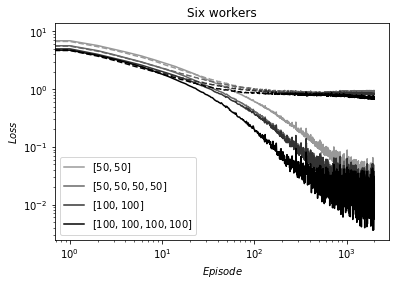

In [14]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=r"${}$".format(net.shape))
    ax.plot(losstest, "k--", color=str(c))
    
# plot settings
ax.set_title("Six workers")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

# e) Two star

In [15]:
def train_2star(net, idat, odat, epo=1000, lr=1e-4, gpu=False, ptest=0.1):
    
    # if you are smart
    if gpu:
        net.cuda()
        idat = idat.cuda()
        odat = odat.cuda()
        
    # if you are not
    else:
        net.cpu()
        idat = idat.cpu()
        odat = odat.cpu()
        
    # number of testing data points
    n = int(idat.shape[0]*ptest)
    
    # batches of testing data
    itstb = idat[:n, :].chunk(4)
    otstb = odat[:n, :].chunk(4)
    
    # batches of training data
    itrnb = idat[n:, :].chunk(4)
    otrnb = odat[n:, :].chunk(4)
        
    # optimisation algorithm
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss function
    lf = torch.nn.MSELoss()
    
    # loss records
    training_loss = list()
    testing_loss  = list()
    
    # training iterations
    for e in range(epo):
        
        # losses
        ltrn, ltst = 0, 0
        
        # first star
        for itst, otst, itrn, otrn in zip(itstb[:2], otstb[:2], itrnb[:2], otrnb[:2]):
            
            # zero the gradients
            opt.zero_grad()
            
            # compute losses with noise
            loss_train = lf(net(itrn) + np.random.normal(0, 0.1), otrn)
            loss_test  = lf(net(itst) + np.random.normal(0, 0.1), otst)
            
            # records losses
            ltrn += loss_train.item()
            ltst += loss_test.item()
            
            # accumulate gradient
            loss_train.backward()
            
            # take an optimisation step
            opt.step()
            
        # record the average loss across batches
        ltrn /= 2
        ltst /= 2
        training_loss.append(ltrn)
        testing_loss.append(ltst)
            
        # losses
        ltrn, ltst = 0, 0
            
        # second star
        for itst, otst, itrn, otrn in zip(itstb[2:], otstb[2:], itrnb[2:], otrnb[2:]):
            
            # zero the gradients
            opt.zero_grad()
            
            # compute losses with noise
            loss_train = lf(net(itrn) + np.random.normal(0, 0.1), otrn)
            loss_test  = lf(net(itst) + np.random.normal(0, 0.1), otst)
            
            # records losses
            ltrn += loss_train.item()
            ltst += loss_test.item()
            
            # accumulate gradient
            loss_train.backward()
            
            # take an optimisation step
            opt.step()
        
        # record the average loss across batches
        ltrn /= 2
        ltst /= 2
        training_loss.append(ltrn)
        testing_loss.append(ltst)
        
        # print progress
        clear_output(wait=True)
        print("Episode {}; Training Loss {}; Testing Loss {}".format(e, ltrn, ltst))
        
    return net.cpu(), training_loss, testing_loss

In [16]:
# considered architectures
args = [
    (DNN([50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst),
    (DNN([50, 50, 50, 50]), idat[:n], odat[:n], epo, lr, gpu, ptst),
    (DNN([100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst),
    (DNN([100, 100, 100, 100]), idat[:n], odat[:n], epo, lr, gpu, ptst)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train_2star, args)

Episode 1999; Training Loss 0.018066714517772198; Testing Loss 0.9684748351573944


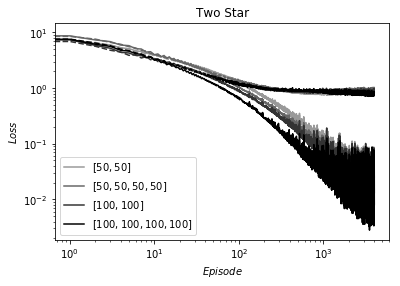

In [17]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=r"${}$".format(net.shape))
    ax.plot(losstest, "k--", color=str(c))
    
# plot settings
ax.set_title("Two Star")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

# f) Using dropout

In [18]:
# considered architectures
args = [
    (DNN([50, 50], dropout=True), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([50, 50, 50, 50], dropout=True), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([100, 100], dropout=True), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([100, 100, 100, 100], dropout=True), idat[:n], odat[:n], epo, lr, gpu, ptst, 1)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train, args)

Episode 1999; Training Loss 0.5813037157058716; Testing Loss 1.2532483339309692


In [19]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=r"${}$".format(net.shape))
    ax.plot(losstest, "k--", color=str(c))
    
# plot settings
ax.set_title("Dropout")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

Having the network be fully connected encourages codependancy among nodes, which alters the influence of each node in the network, eventually leading to overfitting.
Including dropout in training encourages learning of independant features, thus preventing overfitting and leading to better generalisation performance.
As before, larger architectures achieve better training and generalisation performance.
However, we see now, with the inclusion of dropout, that every network generalises a bit better.

# g) Improving smoothness

In [20]:
# considered architectures
args = [
    (DNN([100, 100, 100, 100], norm="batch"), idat[:n], odat[:n], epo, lr, gpu, ptst, 1),
    (DNN([100, 100, 100, 100], norm="layer"), idat[:n], odat[:n], epo, lr, gpu, ptst, 1)
]

# train all of these nets in parallel on the GPU
resl = mp.Pool(len(args)).starmap(train, args)

Episode 1999; Training Loss 0.005849427077919245; Testing Loss 1.021254062652588


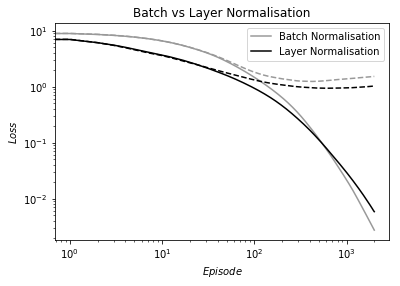

In [21]:
# plot the training losses
fig, ax = plt.subplots(1)

# grayscale
colours = np.linspace(0.6, 0, len(args))

# labels
labels = ["Batch Normalisation", "Layer Normalisation"]

i = 0
for res, c in zip(resl, colours):
    
    # get results
    net, losstrain, losstest = res
    
    # plot results
    ax.plot(losstrain, "k-", color=str(c), label=labels[i])
    ax.plot(losstest, "k--", color=str(c))
    
    i += 1
    
# plot settings
ax.set_title("Batch vs Layer Normalisation")
ax.set_xlabel(r"$Episode$")
ax.set_ylabel(r"$Loss$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

Batch normalisation uses the statistics of the batches, while layer normalisation uses the statistics from the network layer outputs.
Batch normalisation works well, but layer normalisation works better.